In [ ]:
import importlib, types, sys
# Provide a tiny shim so "from imp import reload" works
sys.modules['imp'] = types.SimpleNamespace(reload=importlib.reload)


%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os

# TODO: Fill in the Google Drive path where you uploaded assignment1
# Example: If you create a Fall2023 folder and put all the files under A1 folder, then 'Fall2023/A1'
GOOGLE_DRIVE_PATH_POST_MYDRIVE = 'CS7643_project-main'
GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive', 'MyDrive', GOOGLE_DRIVE_PATH_POST_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

# if running locally set GOOGLE PATH
import sys
if 'google.colab' in sys.modules:
  print(f'Running in google colab. Our path is `{GOOGLE_DRIVE_PATH}`')
else:
  GOOGLE_DRIVE_PATH = '.'
  print('Running locally.')



import sys
import numpy as np
import math
sys.path.append(GOOGLE_DRIVE_PATH)
print(os.listdir(GOOGLE_DRIVE_PATH))

import os
os.chdir('/content/drive/MyDrive/CS7643_project-main')
print(os.getcwd())

import os, json, time, random
import numpy as np
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from PIL import Image
from tqdm import tqdm

from transformers import (
    VisionEncoderDecoderModel,
    AutoTokenizer,
    ViTImageProcessor,
    AutoModel,
    AutoModelForCausalLM,
)
from peft import LoraConfig, get_peft_model, TaskType, PeftModel

import os, json, math
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

from transformers import VisionEncoderDecoderModel, AutoTokenizer, ViTImageProcessor
from peft import PeftModel

# Optional COCO-style metrics (same suite you used: BLEU/METEOR/ROUGE-L/CIDEr)
_HAS_COCO = False
try:
    from pycocoevalcap.bleu.bleu import Bleu
    from pycocoevalcap.meteor.meteor import Meteor
    from pycocoevalcap.rouge.rouge import Rouge
    from pycocoevalcap.cider.cider import Cider
    _HAS_COCO = True
except Exception:
    _HAS_COCO = False



Mounted at /content/drive
['daily_task_tracker.md', 'project_roadmap.md', 'image_caption_training.ipynb', 'data_download.ipynb', 'image_caption_evaluation.ipynb', 'image_caption_generation.ipynb', 'data_preprocessing.ipynb', '.gitignore', '.git', 'analysis', 'configs', 'evaluation', 'data', 'Flicker8k_captions', 'Flickr8k_Data', 'generation', 'image-captioning-model', 'lora-experiments', 'models', 'lora_training_experiments.ipynb', 'lora-experiments-v2', 'image_caption_training (full model).ipynb', 'lora_training_experiments_v2 copy.ipynb', 'ablations_out', 'ablations_out_10', 'ablations_out_25', 'ablations_out_8_16']
Running in google colab. Our path is `/content/drive/MyDrive/CS7643_project-main`
['daily_task_tracker.md', 'project_roadmap.md', 'image_caption_training.ipynb', 'data_download.ipynb', 'image_caption_evaluation.ipynb', 'image_caption_generation.ipynb', 'data_preprocessing.ipynb', '.gitignore', '.git', 'analysis', 'configs', 'evaluation', 'data', 'Flicker8k_captions', 'Fli

In [ ]:
@dataclass
class CFG:
    IMG_DIR: str = r'./Flickr8k_Data/Flicker8k_Dataset_resized'
    CAP_DIR: str = r'./Flicker8k_captions'
    OUT_DIR: str = r'./ablations_out_25'

    # model ids
    NEG_VIT: str = "google/vit-base-patch16-224-in21k"
    NEG_GPT2: str = "gpt2"
    PRETRAINED_CAPTIONER: str = "nlpconnect/vit-gpt2-image-captioning"

    # training
    MAX_LEN: int = 48
    BATCH_SIZE: int = 32
    EPOCHS: int = 2
    GRAD_ACCUM: int = 8
    LR_DENSE: float = 5e-6          # dense should generally be tiny
    LR_LORA: float = 1e-4           # LoRA can be much larger
    WEIGHT_DECAY: float = 0.0
    SEED: int = 42

    # LoRA
    LORA_R: int = 8
    LORA_ALPHA: int = 32
    LORA_DROPOUT: float = 0.1

cfg = CFG()

# -------------------------
# Model/tokenizer helpers
# -------------------------
def ensure_pad(tokenizer):
    if tokenizer.pad_token is None and tokenizer.eos_token is not None:
        tokenizer.pad_token = tokenizer.eos_token
    return tokenizer

def configure_for_captioning(model, tokenizer):
    model.config.pad_token_id = tokenizer.pad_token_id
    if model.config.eos_token_id is None and tokenizer.eos_token_id is not None:
        model.config.eos_token_id = tokenizer.eos_token_id
    if model.config.decoder_start_token_id is None:
        model.config.decoder_start_token_id = model.config.eos_token_id
    model.config.use_cache = False
    return model


def resolve_adapter_dir(dec_root: str) -> str:
    # If adapter_config is directly there, great.
    if os.path.isfile(os.path.join(dec_root, "adapter_config.json")):
        return dec_root

    # Otherwise, search one level down (e.g., decoder_lora/lora_all/adapter_config.json)
    if os.path.isdir(dec_root):
        for sub in os.listdir(dec_root):
            cand = os.path.join(dec_root, sub)
            if os.path.isfile(os.path.join(cand, "adapter_config.json")):
                return cand

    raise FileNotFoundError(f"No adapter_config.json found in {dec_root} (or its immediate subfolders).")

def load_run_model(run_dir: str):
    """
    Loads:
      - pre+lora format: run_dir/lora_model_info.json + decoder_lora/
      - otherwise: run_dir as regular HF VisionEncoderDecoderModel
    Returns (model, tokenizer, processor)
    """
    info_path = os.path.join(run_dir, "lora_model_info.json")
    print(f"Info Path: {info_path}")

    # tokenizer
    tokenizer = AutoTokenizer.from_pretrained(run_dir)
    tokenizer = ensure_pad(tokenizer)

    if os.path.exists(info_path):
        with open(info_path, "r") as f:
            info = json.load(f)

        base_path = info["base_model_path"]
        model = VisionEncoderDecoderModel.from_pretrained(base_path)
        model = configure_for_captioning(model, tokenizer)

        # decoder LoRA
        dec_root = os.path.join(run_dir, "decoder_lora")
        dec_root = resolve_adapter_dir(dec_root)
        model.decoder = PeftModel.from_pretrained(model.decoder, dec_root)

        # processor: match captioner base
        processor = ViTImageProcessor.from_pretrained(base_path)
    else:
        model = VisionEncoderDecoderModel.from_pretrained(run_dir)
        model = configure_for_captioning(model, tokenizer)

        # pick processor based on the run type if local processor isn't present
        try:
            processor = ViTImageProcessor.from_pretrained(run_dir)
        except Exception:
            # read base_kind from train_history.json to choose correct processor
            hist_path = os.path.join(run_dir, "train_history.json")
            base_kind = None
            if os.path.exists(hist_path):
                with open(hist_path, "r") as f:
                    base_kind = json.load(f).get("base_kind", None)

            if base_kind == "pre":
                processor = ViTImageProcessor.from_pretrained(cfg.PRETRAINED_CAPTIONER)
            else:
                processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")


    model.to(DEVICE).eval()
    return model, tokenizer, processor

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

import numpy as np

def enhance_heat(heat, *, thresh=0.15, gamma=0.6):
    """
    heat: HxW in [0,1] (or arbitrary, we'll normalize)
    thresh: pushes small values toward 0 (more black background)
    gamma < 1: boosts mid/high values (more prominent hotspots)
    """
    h = heat.astype(np.float32)
    h = (h - h.min()) / (h.max() - h.min() + 1e-8)
    # threshold + rescale
    h = np.clip((h - thresh) / (1.0 - thresh + 1e-8), 0.0, 1.0)
    # gamma contrast
    h = np.power(h, gamma)
    return h


def vit_patch_grid(model):
    # ViT base patch16 @224: 14x14 patches (plus CLS)
    # infer from encoder config if possible
    enc = model.encoder
    patch = enc.config.patch_size if hasattr(enc.config, "patch_size") else 16
    img = enc.config.image_size if hasattr(enc.config, "image_size") else 224
    g = img // patch
    return g, g

@torch.no_grad()
def preprocess_image(processor, img_path):
    img = Image.open(img_path).convert("RGB")
    pv = processor(img, return_tensors="pt").pixel_values
    return img, pv


def token_attribution_heatmap_first_k(
    model, tokenizer, processor, img_path, caption_text, k=5, alpha=0.45
):
    model.eval()
    model.to(DEVICE)

    # 1) prep
    img, pixel_values = preprocess_image(processor, img_path)
    pixel_values = pixel_values.to(DEVICE)

    # teacher-forced caption -> decoder inputs
    tok = tokenizer(caption_text, return_tensors="pt")
    input_ids = tok["input_ids"].to(DEVICE)
    decoder_input_ids = input_ids[:, :-1].contiguous()

    torch.set_grad_enabled(True)

    # 2) encoder forward (keep grads on encoder tokens)
    enc_out = model.encoder(pixel_values=pixel_values, output_hidden_states=True, return_dict=True)
    enc_tokens = enc_out.last_hidden_state                 # [1, 1+N, D]
    enc_tokens.retain_grad()

    # 3) decoder forward conditioned on encoder tokens
    dec_out = model.decoder(
        input_ids=decoder_input_ids,
        encoder_hidden_states=enc_tokens,
        encoder_attention_mask=None,
        return_dict=True,
    )
    logits = dec_out.logits                                # [1, T, V]  (T = len(decoder_input_ids))

    # predicted tokens per timestep (argmax)
    pred_ids_all = logits.argmax(dim=-1)[0]                # [T]
    print("Argmax token ids per step:", pred_ids_all.tolist())
    print("Decoded (argmax) sequence:", repr(tokenizer.decode(pred_ids_all.tolist(), skip_special_tokens=False)))

    T = logits.shape[1]
    K = min(k, T)
    if K == 0:
        print("Nothing to visualize (T=0). Try a longer caption_text.")
        return

    # figure
    fig, axes = plt.subplots(1, K, figsize=(4 * K, 4))
    if K == 1:
        axes = [axes]

    gh, gw = vit_patch_grid(model)

    for t in range(K):
        pred_id = int(pred_ids_all[t].item())
        token_str = tokenizer.decode([pred_id])

        # clear grads
        model.zero_grad(set_to_none=True)
        if enc_tokens.grad is not None:
            enc_tokens.grad.zero_()

        # backprop score for this timestep/token
        score = logits[0, t, pred_id]
        score.backward(retain_graph=(t < K - 1))

        # grad -> per-patch importance (exclude CLS)
        grads = enc_tokens.grad[0, 1:, :]                  # [N, D]
        acts  = enc_tokens.detach()[0, 1:, :]              # [N, D]
        patch_scores = (grads * acts).abs().mean(dim=-1)   # [N]
        patch_scores = patch_scores / (patch_scores.max() + 1e-8)

        heat = patch_scores.reshape(gh, gw).detach().cpu().numpy()
        heat = torch.tensor(heat)[None, None, ...]
        heat = F.interpolate(
            heat, size=img.size[::-1], mode="bilinear", align_corners=False
        )[0, 0].numpy()

        ax = axes[t]
        ax.imshow(img)
        ax.imshow(heat, alpha=alpha)
        ax.axis("off")
        ax.set_title(f"t={t}: {token_str!r}")

    plt.tight_layout()
    plt.show()

def token_attribution_heatmap_first_k(
    model,
    tokenizer,
    processor,
    img_path,
    caption_text,
    k=5,
    *,
    thresh=0.15,
    gamma=0.6,
    darken_strength=0.55,
    heat_alpha=0.85,
    suptitle: str | None = None,   
):
    model.eval()
    model.to(DEVICE)

    img, pixel_values = preprocess_image(processor, img_path)
    pixel_values = pixel_values.to(DEVICE)

    tok = tokenizer(caption_text, return_tensors="pt")
    input_ids = tok["input_ids"].to(DEVICE)
    decoder_input_ids = input_ids[:, :-1].contiguous()

    torch.set_grad_enabled(True)

    enc_out = model.encoder(pixel_values=pixel_values, output_hidden_states=True, return_dict=True)
    enc_tokens = enc_out.last_hidden_state
    enc_tokens.retain_grad()

    dec_out = model.decoder(
        input_ids=decoder_input_ids,
        encoder_hidden_states=enc_tokens,
        encoder_attention_mask=None,
        return_dict=True,
    )
    logits = dec_out.logits

    pred_ids_all = logits.argmax(dim=-1)[0]
    print("Argmax token ids per step:", pred_ids_all.tolist())
    print("Decoded (argmax) sequence:", repr(tokenizer.decode(pred_ids_all.tolist(), skip_special_tokens=False)))

    T = logits.shape[1]
    K = min(k, T)
    if K == 0:
        print("Nothing to visualize (T=0). Try a longer caption_text.")
        return

    gh, gw = vit_patch_grid(model)

    fig, axes = plt.subplots(1, K, figsize=(4 * K, 4))
    if K == 1:
        axes = [axes]

    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=12)
        fig.subplots_adjust(top=0.80)

    for t in range(K):
        pred_id = int(pred_ids_all[t].item())
        token_str = tokenizer.decode([pred_id])

        model.zero_grad(set_to_none=True)
        if enc_tokens.grad is not None:
            enc_tokens.grad.zero_()

        score = logits[0, t, pred_id]
        score.backward(retain_graph=(t < K - 1))

        grads = enc_tokens.grad[0, 1:, :]
        acts  = enc_tokens.detach()[0, 1:, :]
        patch_scores = (grads * acts).abs().mean(dim=-1)
        patch_scores = patch_scores / (patch_scores.max() + 1e-8)

        heat = patch_scores.reshape(gh, gw).detach().cpu().numpy()
        heat = torch.tensor(heat)[None, None, ...]
        heat = F.interpolate(heat, size=img.size[::-1], mode="bilinear", align_corners=False)[0, 0].cpu().numpy()

        heat = enhance_heat(heat, thresh=thresh, gamma=gamma)

        ax = axes[t]
        ax.imshow(img)
        ax.imshow(np.zeros_like(heat), cmap="gray", alpha=darken_strength * (1.0 - heat))
        ax.imshow(heat, cmap="inferno", alpha=heat_alpha * heat)
        ax.axis("off")
        ax.set_title(f"t={t}: {token_str!r}", fontsize=10)

    plt.tight_layout()
    plt.show()


def list_runs(out_dir: str):
    runs = []
    for sub in sorted(os.listdir(out_dir)):
        run_dir = os.path.join(out_dir, sub)
        if not os.path.isdir(run_dir):
            continue
        if os.path.exists(os.path.join(run_dir, "train_history.json")):
            runs.append((sub, run_dir))
    return runs

runs = list_runs(cfg.OUT_DIR)
print(f"Found {len(runs)} run folders with train_history.json")

for run_name, run_dir in runs:
    display = run_name
    print(f"Loading run {display} from {run_dir}")

# Example usage:

def load_pickle(path: str):
    import pickle
    with open(path, "rb") as f:
        return pickle.load(f)

test_data = load_pickle(os.path.join(cfg.CAP_DIR, "test_data.pickle"))
# token_attribution_heatmap(model, tokenizer, processor, "/content/Flickr8k_Data/3385593926_d3e9c21170.jpg", "a dog runs on the grass")

import random





Found 12 run folders with train_history.json
Loading run neg_dense_cross_only_r8_e25 from ./ablations_out_25/neg_dense_cross_only_r8_e25
Loading run neg_dense_cross_plus_ln_r8_e25 from ./ablations_out_25/neg_dense_cross_plus_ln_r8_e25
Loading run neg_dense_cross_plus_selfattn_r8_e25 from ./ablations_out_25/neg_dense_cross_plus_selfattn_r8_e25
Loading run neg_lora_cross_only_r8_e25 from ./ablations_out_25/neg_lora_cross_only_r8_e25
Loading run neg_lora_cross_plus_ln_r8_e25 from ./ablations_out_25/neg_lora_cross_plus_ln_r8_e25
Loading run neg_lora_cross_plus_selfattn_r8_e25 from ./ablations_out_25/neg_lora_cross_plus_selfattn_r8_e25
Loading run pre_dense_cross_only_r8_e25 from ./ablations_out_25/pre_dense_cross_only_r8_e25
Loading run pre_dense_cross_plus_ln_r8_e25 from ./ablations_out_25/pre_dense_cross_plus_ln_r8_e25
Loading run pre_dense_cross_plus_selfattn_r8_e25 from ./ablations_out_25/pre_dense_cross_plus_selfattn_r8_e25
Loading run pre_lora_cross_only_r8_e25 from ./ablations_out_2

In [ ]:
def _force_eager_attn(model):
    # Make sure both the wrapper + underlying decoder are set to eager
    objects = [
        model,
        getattr(model, "encoder", None),
        getattr(model, "decoder", None),
        getattr(getattr(model, "decoder", None), "base_model", None),         # PeftModel
        getattr(getattr(getattr(model, "decoder", None), "base_model", None), "model", None),
    ]
    for obj in objects:
        if obj is not None and hasattr(obj, "config"):
            # transformers uses this internal field for the attn backend choice
            obj.config._attn_implementation = "eager"
    return model


def load_run_model_eager(run_dir: str):
    info_path = os.path.join(run_dir, "lora_model_info.json")

    tokenizer = AutoTokenizer.from_pretrained(run_dir)
    tokenizer = ensure_pad(tokenizer)

    if os.path.exists(info_path):
        with open(info_path, "r") as f:
            info = json.load(f)

        base_path = info["base_model_path"]

        # load base captioner with eager
        model = VisionEncoderDecoderModel.from_pretrained(base_path, attn_implementation="eager")
        model = configure_for_captioning(model, tokenizer)

        # attach decoder LoRA
        dec_root = os.path.join(run_dir, "decoder_lora")
        dec_root = resolve_adapter_dir(dec_root) 
        model.decoder = PeftModel.from_pretrained(model.decoder, dec_root)

        processor = ViTImageProcessor.from_pretrained(base_path)

    else:
        model = VisionEncoderDecoderModel.from_pretrained(run_dir, attn_implementation="eager")
        model = configure_for_captioning(model, tokenizer)

        try:
            processor = ViTImageProcessor.from_pretrained(run_dir)
        except Exception:
            hist_path = os.path.join(run_dir, "train_history.json")
            base_kind = None
            if os.path.exists(hist_path):
                with open(hist_path, "r") as f:
                    base_kind = json.load(f).get("base_kind", None)

            if base_kind == "pre":
                processor = ViTImageProcessor.from_pretrained(cfg.PRETRAINED_CAPTIONER)
            else:
                processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

    model = _force_eager_attn(model)
    model.to(DEVICE).eval()
    return model, tokenizer, processor


models = []
for run_name, run_dir in runs:
    model, tokenizer, processor = load_run_model_eager(run_dir)
    models.append((run_name, model, tokenizer, processor))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/982M [00:00<?, ?B/s]

In [ ]:
# models = []
# for run_name, run_dir in runs:
#     model, tokenizer, processor = load_run_model(run_dir)
#     models.append((model, tokenizer, processor))
# #

Image: 3470951932_27ed74eb0b.jpg
Caption: A boy is running around the bases in a baseball game .


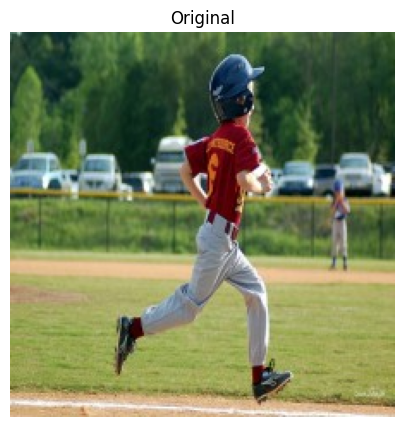

Argmax token ids per step: [286, 257, 257, 257, 257, 764, 257, 2214, 764, 764, 764]
Decoded (argmax) sequence: ' of a a a a . a field . . .'


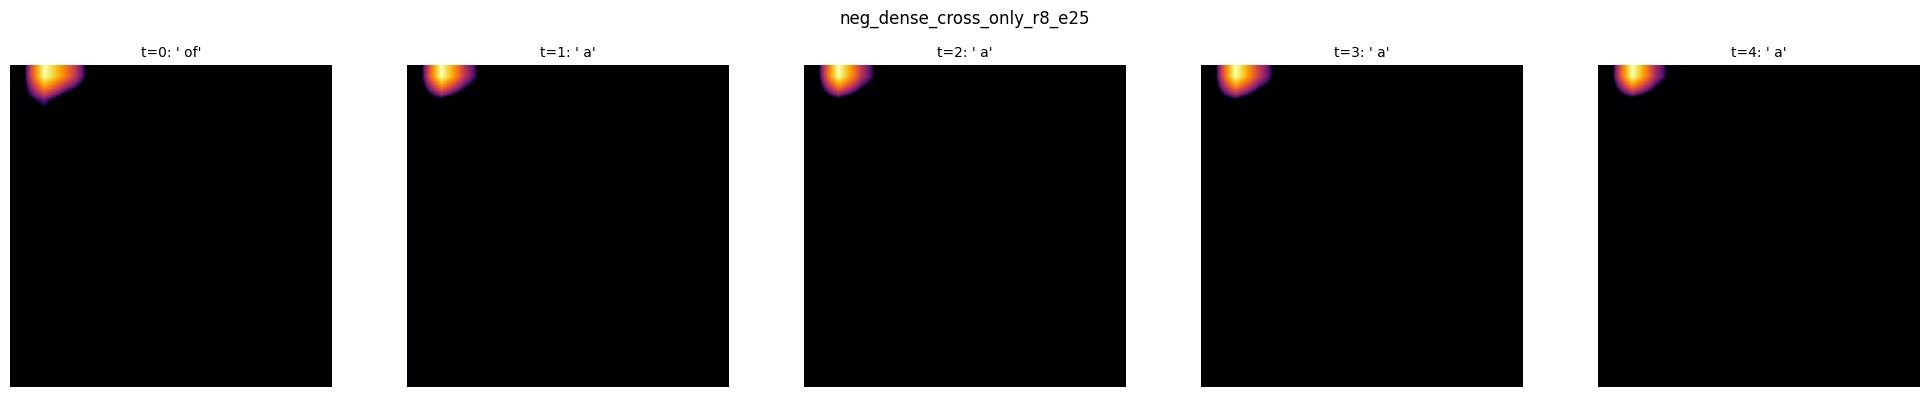

Argmax token ids per step: [287, 257, 257, 257, 2214, 764, 257, 2214, 764, 764, 764]
Decoded (argmax) sequence: ' in a a a field . a field . . .'


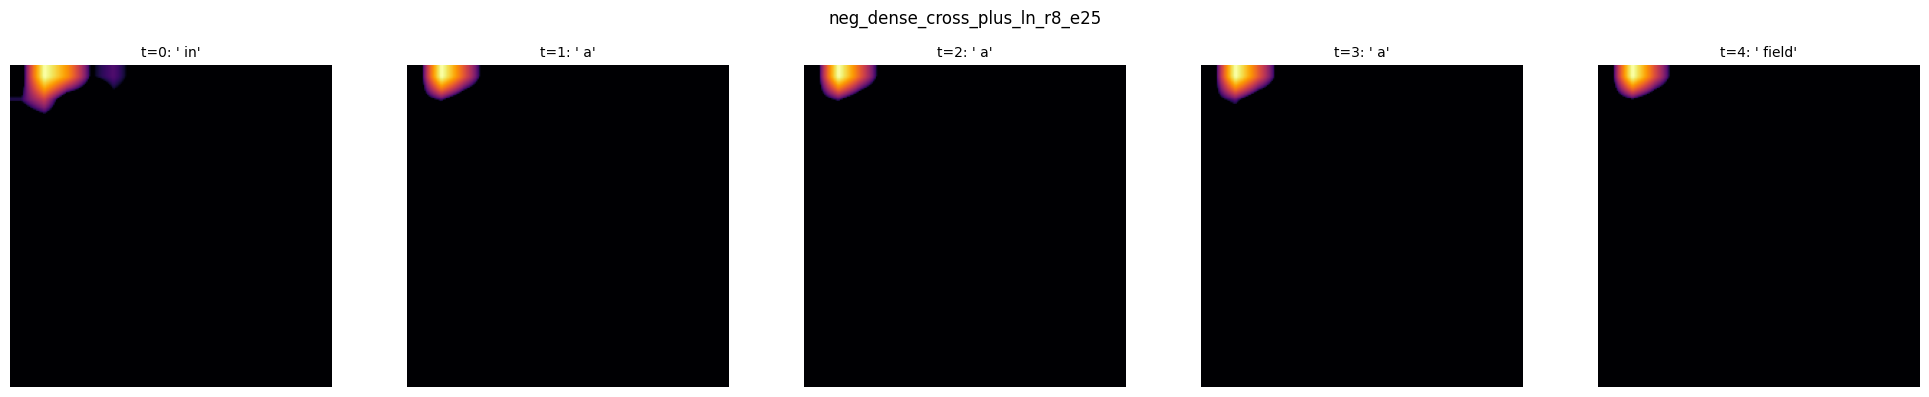

Argmax token ids per step: [287, 257, 257, 257, 2214, 764, 257, 9283, 764, 764, 257]
Decoded (argmax) sequence: ' in a a a field . a baseball . . a'


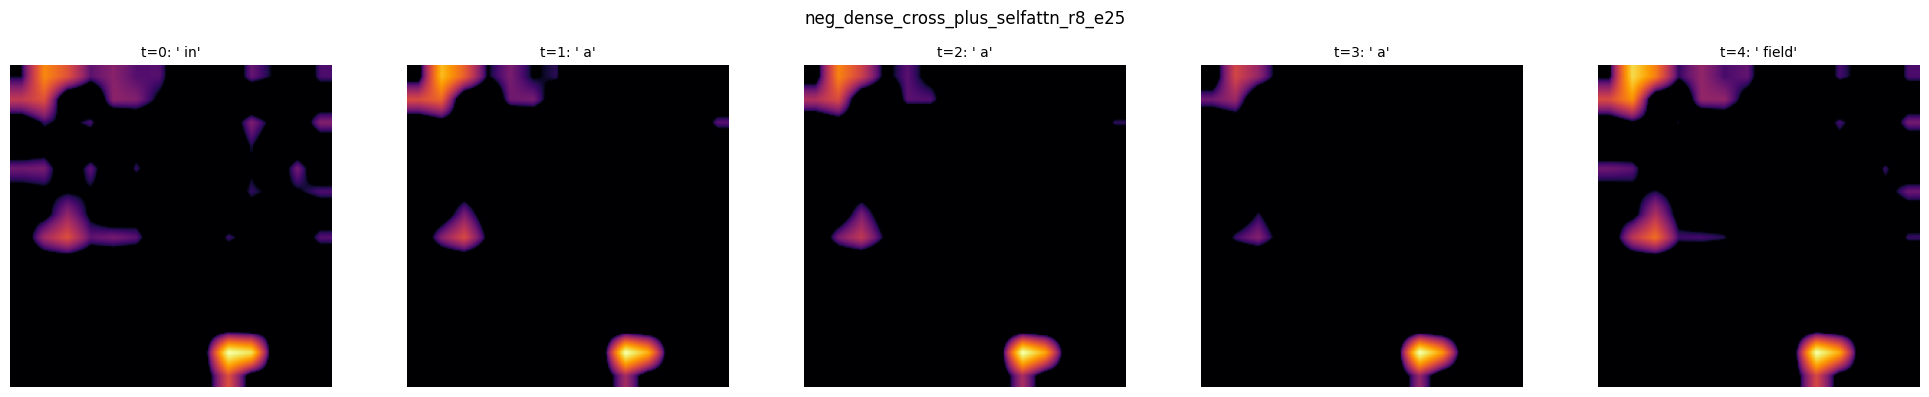

Argmax token ids per step: [318, 257, 257, 257, 257, 351, 257, 286, 764, 764, 257]
Decoded (argmax) sequence: ' is a a a a with a of . . a'


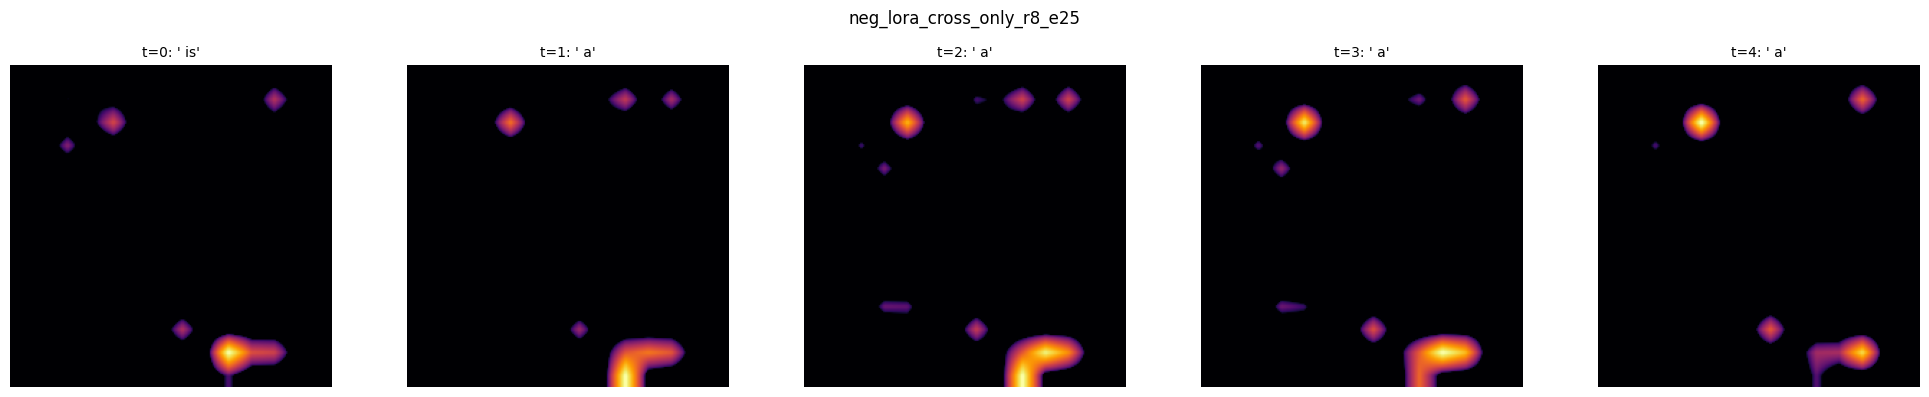

Argmax token ids per step: [287, 257, 257, 257, 257, 764, 257, 286, 764, 764, 257]
Decoded (argmax) sequence: ' in a a a a . a of . . a'


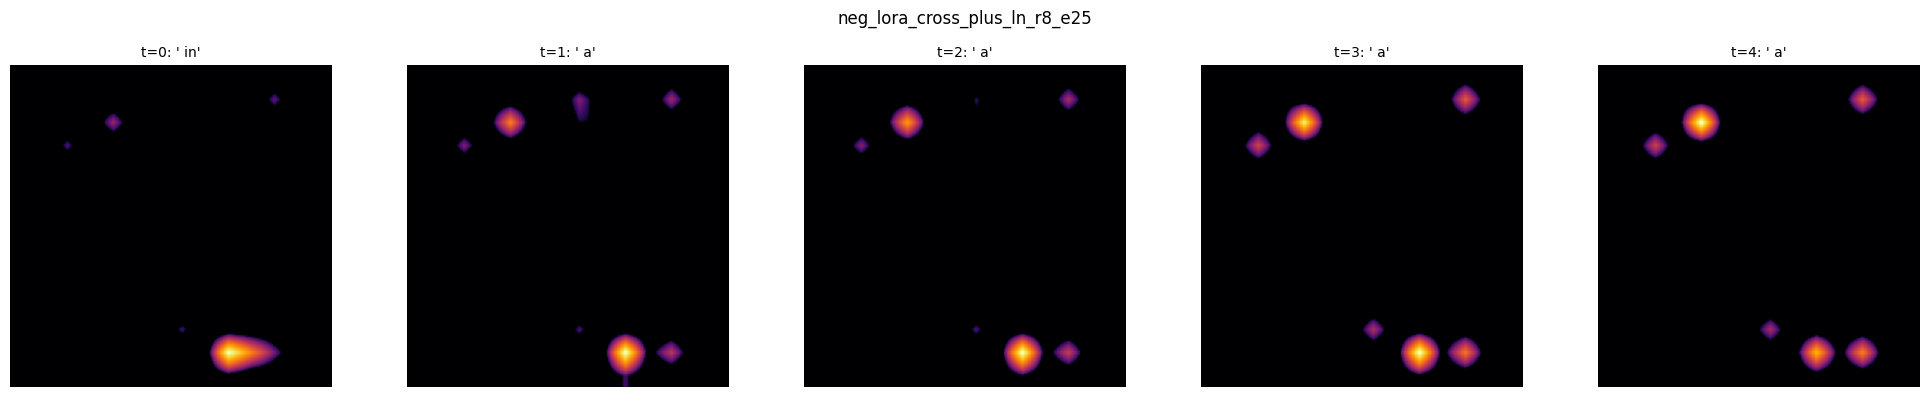

Argmax token ids per step: [287, 257, 257, 257, 2214, 764, 257, 9283, 983, 764, 257]
Decoded (argmax) sequence: ' in a a a field . a baseball game . a'


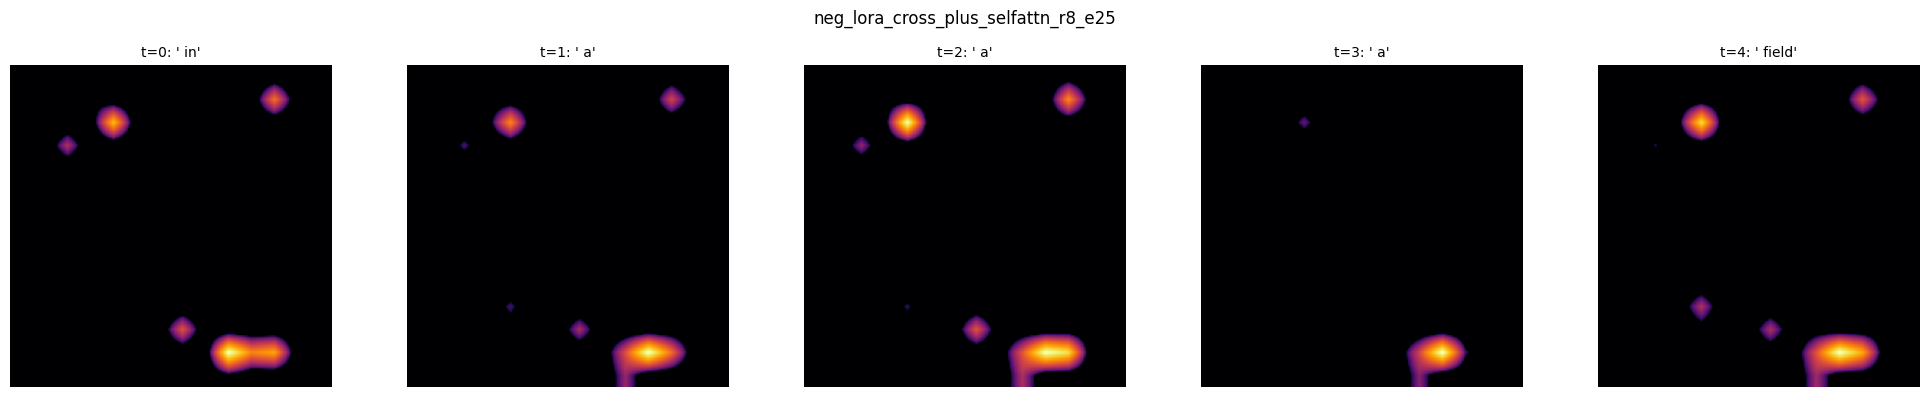

Argmax token ids per step: [2933, 257, 257, 257, 2214, 764, 257, 9283, 764, 764, 764]
Decoded (argmax) sequence: ' boy a a a field . a baseball . . .'


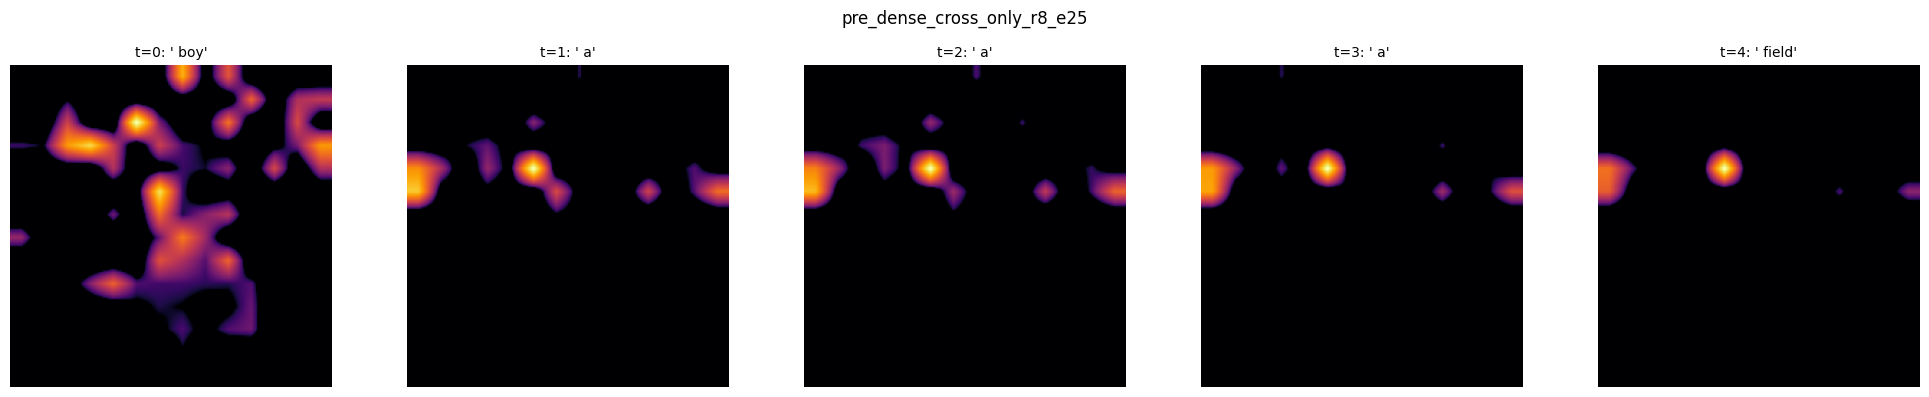

Argmax token ids per step: [2933, 257, 257, 257, 2214, 764, 257, 9283, 764, 764, 764]
Decoded (argmax) sequence: ' boy a a a field . a baseball . . .'


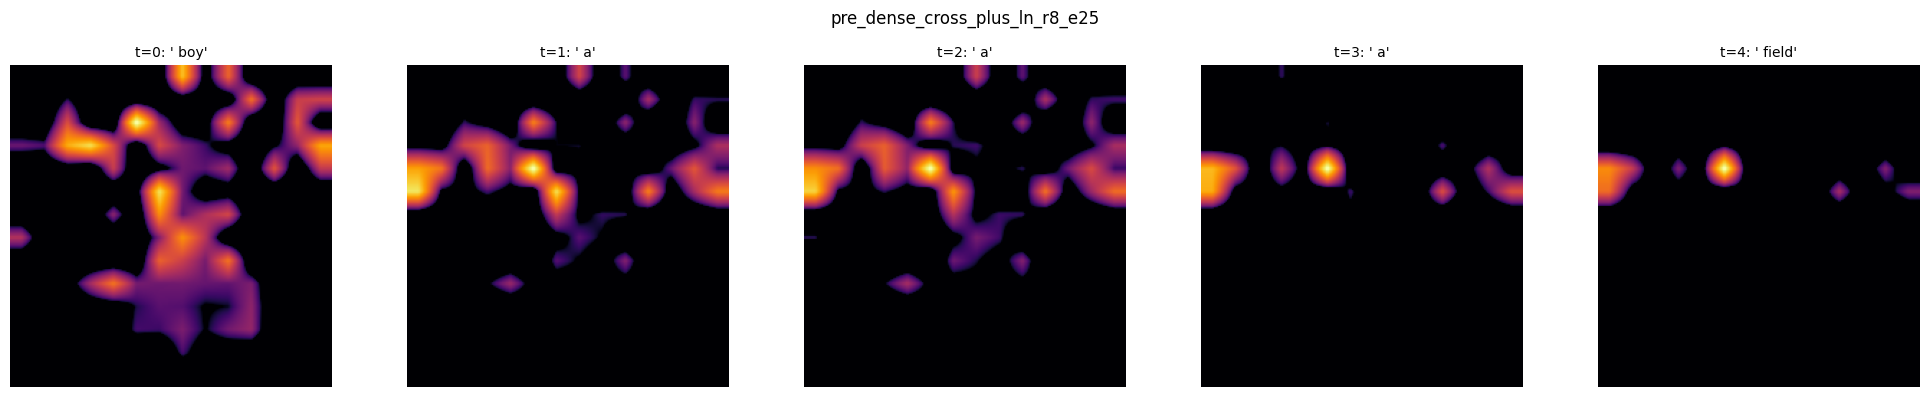

Argmax token ids per step: [2933, 257, 257, 262, 2214, 764, 257, 9283, 983, 764, 257]
Decoded (argmax) sequence: ' boy a a the field . a baseball game . a'


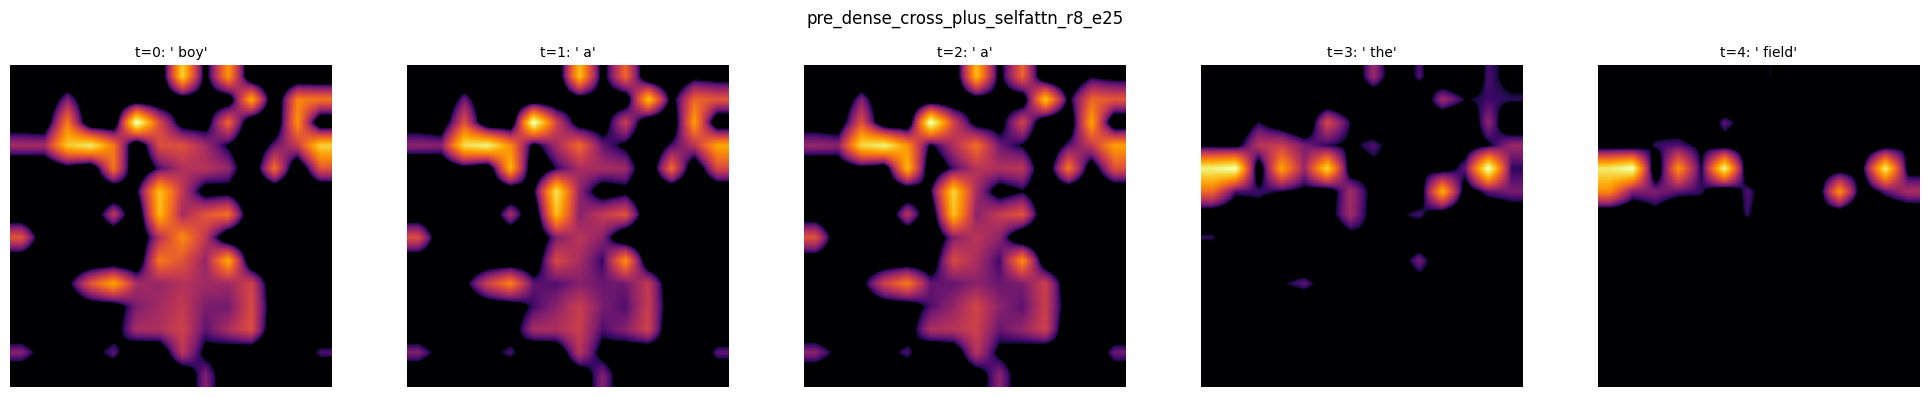

Argmax token ids per step: [2933, 257, 257, 257, 257, 764, 257, 9283, 8187, 764, 257]
Decoded (argmax) sequence: ' boy a a a a . a baseball uniform . a'


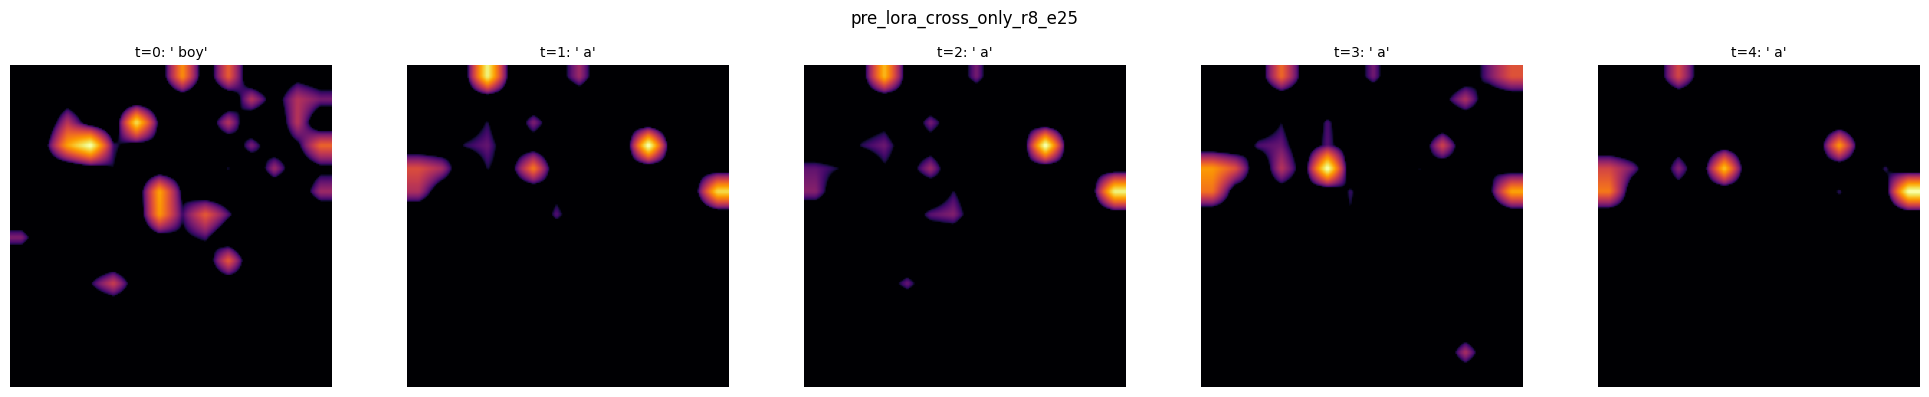

Argmax token ids per step: [2933, 257, 287, 262, 262, 2214, 262, 9283, 9283, 983, 262]
Decoded (argmax) sequence: ' boy a in the the field the baseball baseball game the'


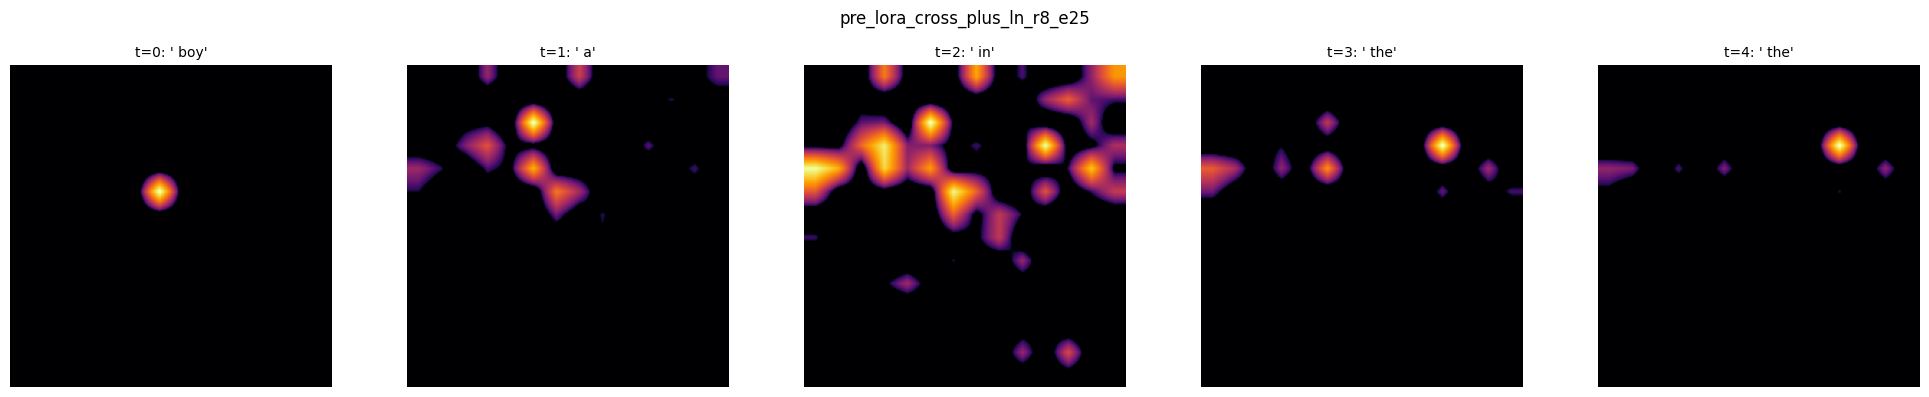

Argmax token ids per step: [2137, 257, 257, 262, 2214, 764, 257, 286, 764, 764, 257]
Decoded (argmax) sequence: ' player a a the field . a of . . a'


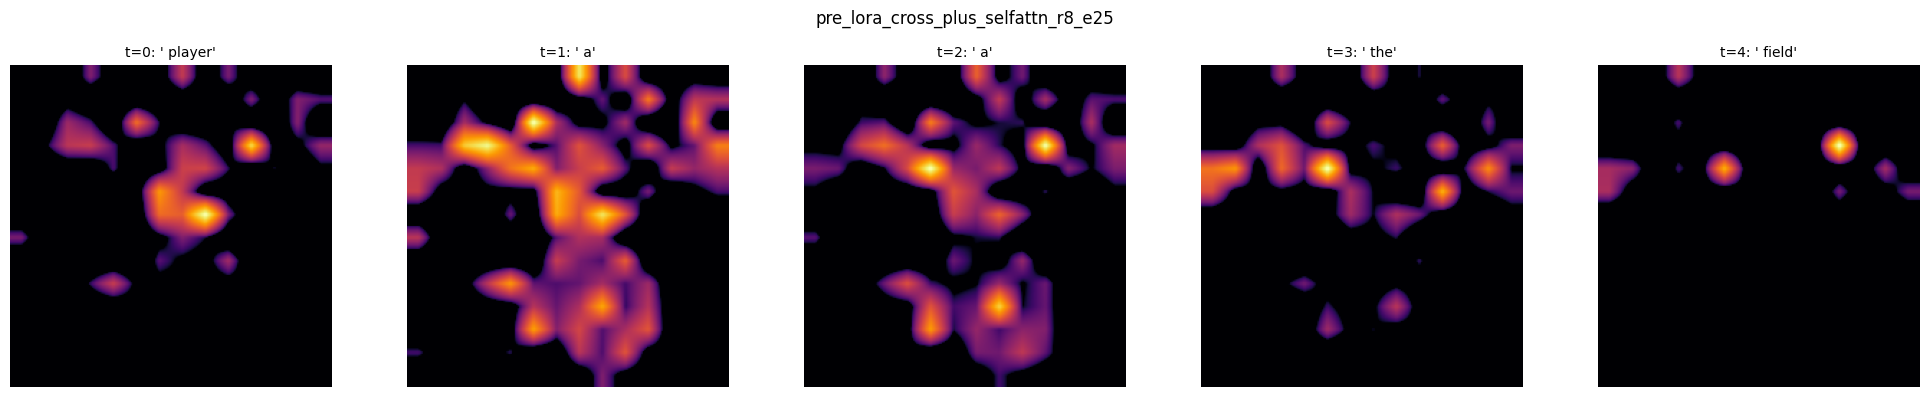

In [ ]:
fn = random.choice(list(test_data.keys()))
caption_text = random.choice(test_data[fn])
img_path = os.path.join(cfg.IMG_DIR, fn)

print("Image:", fn)
print("Caption:", caption_text)
# token_attribution_heatmap_first_k(model, tokenizer, processor, img_path, caption_text, 5)

img0 = Image.open(img_path).convert("RGB")
plt.figure(figsize=(5,5))
plt.imshow(img0)
plt.axis("off")
plt.title("Original")
plt.show()


for run_name, model, tokenizer, processor in models:
    token_attribution_heatmap_first_k(
        model, tokenizer, processor,
        img_path,
        caption_text,
        k=5,
        thresh=0.2,
        gamma=0.5,
        darken_strength=0.6,
        heat_alpha=0.9,
        suptitle=run_name,
    )



Image: 3470951932_27ed74eb0b.jpg
Caption: A boy is running around the bases in a baseball game .


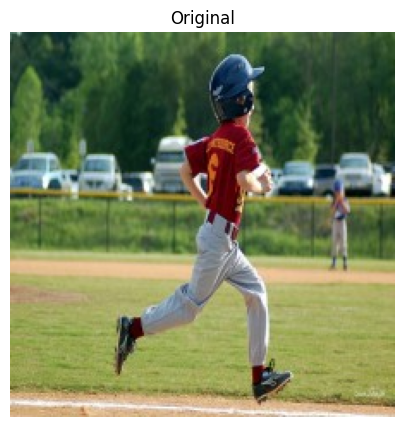

Generated tokens:
 in  black  is  a  playing


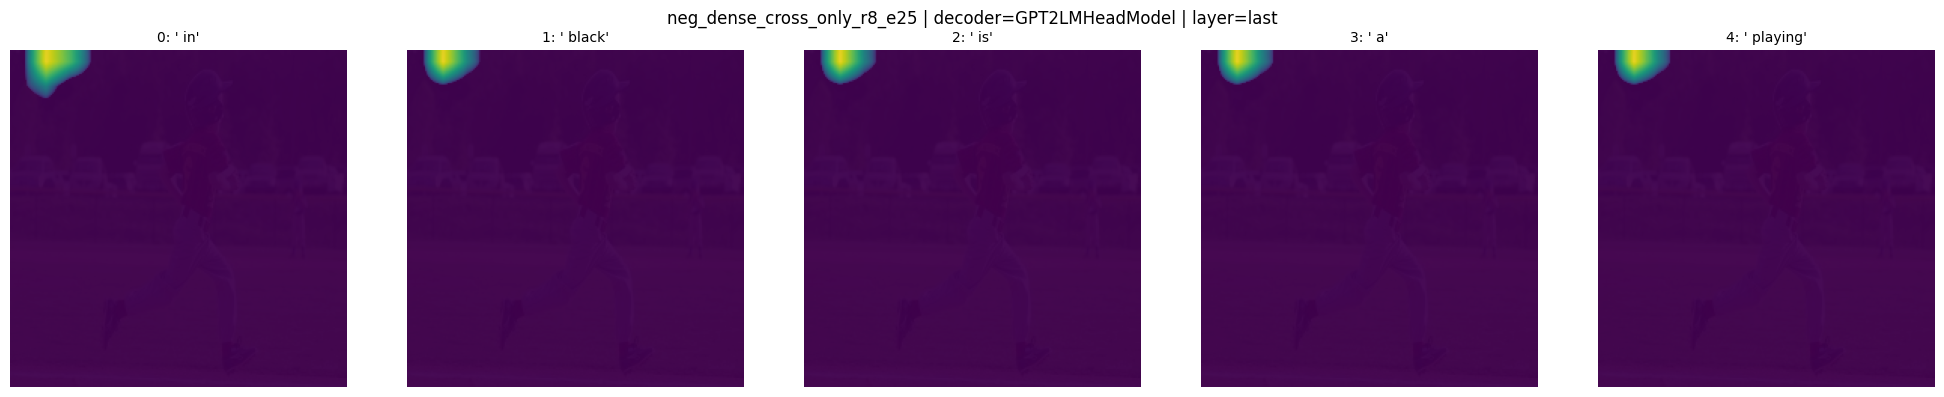

Generated tokens:
 in  black  is  a  and


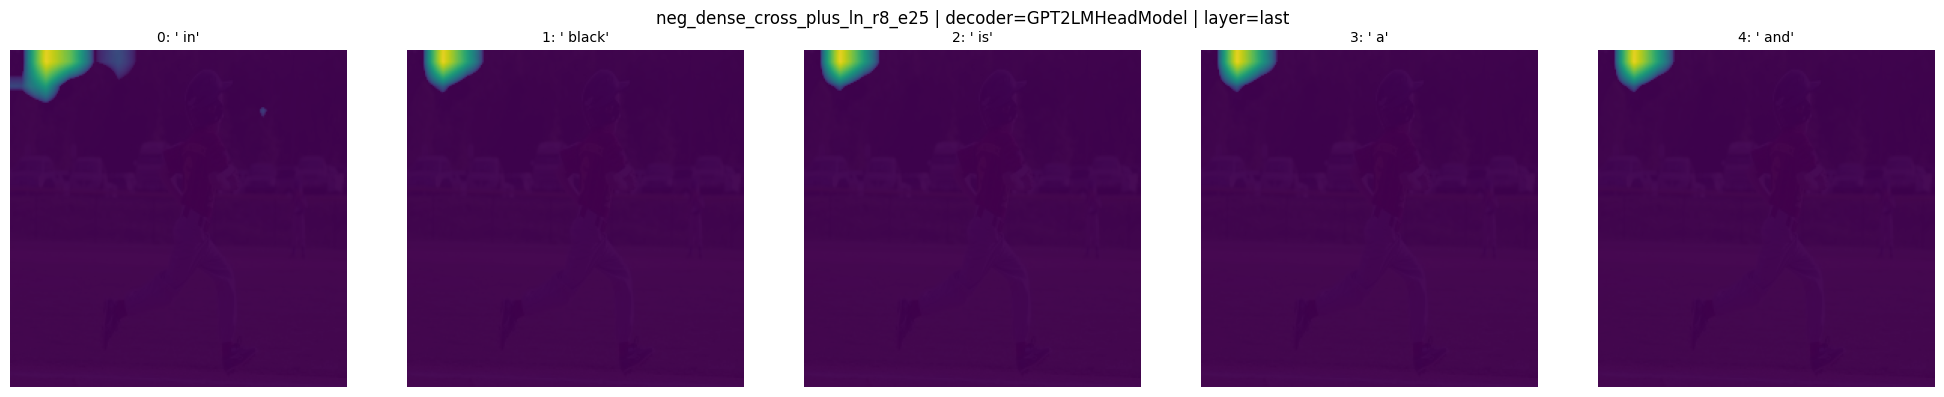

Generated tokens:
 in  shirt  a  shirt  a


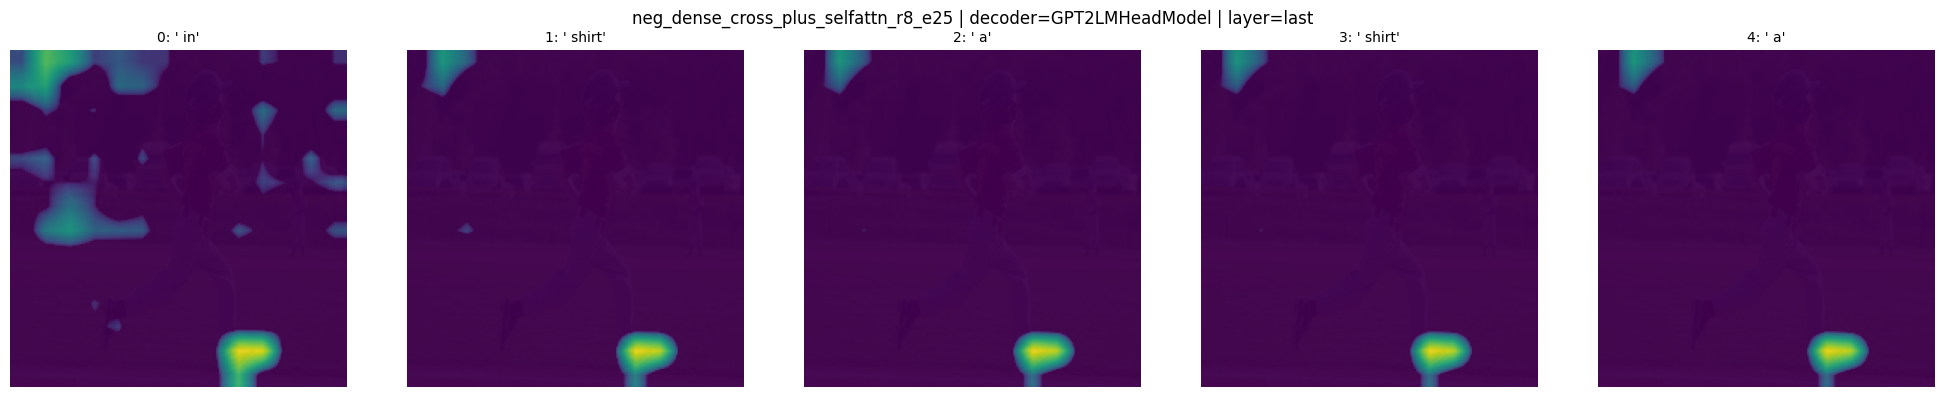

Generated tokens:
 in  of  is  with  dog


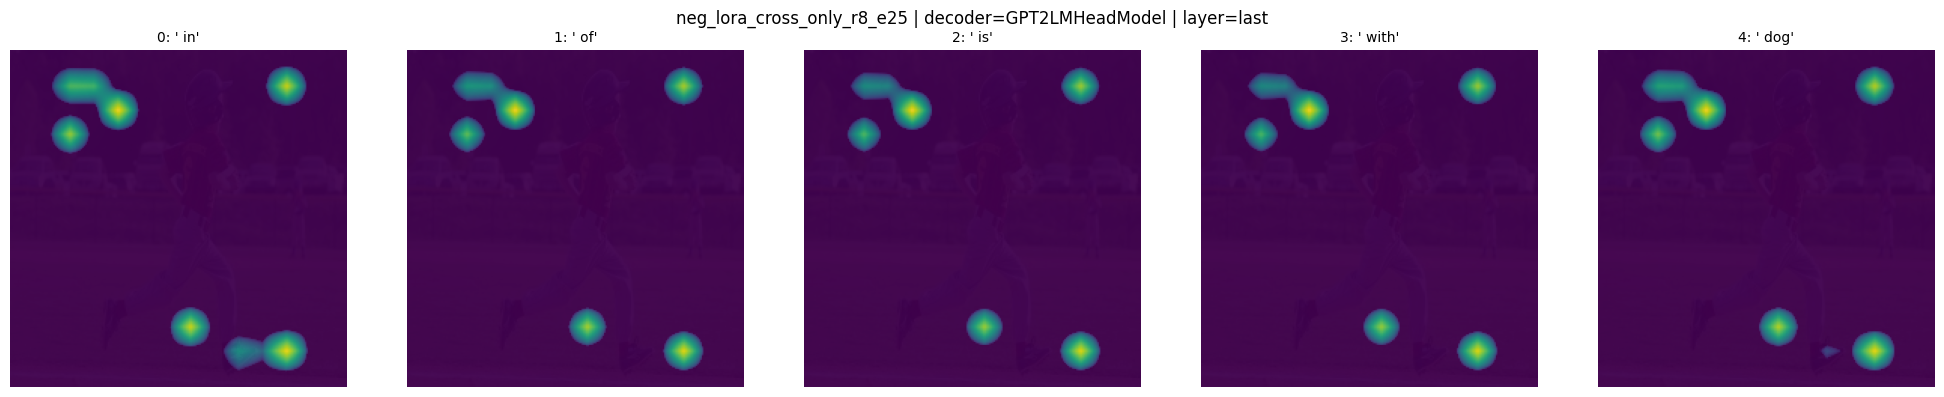

Generated tokens:
 in  and  shirt  a  is


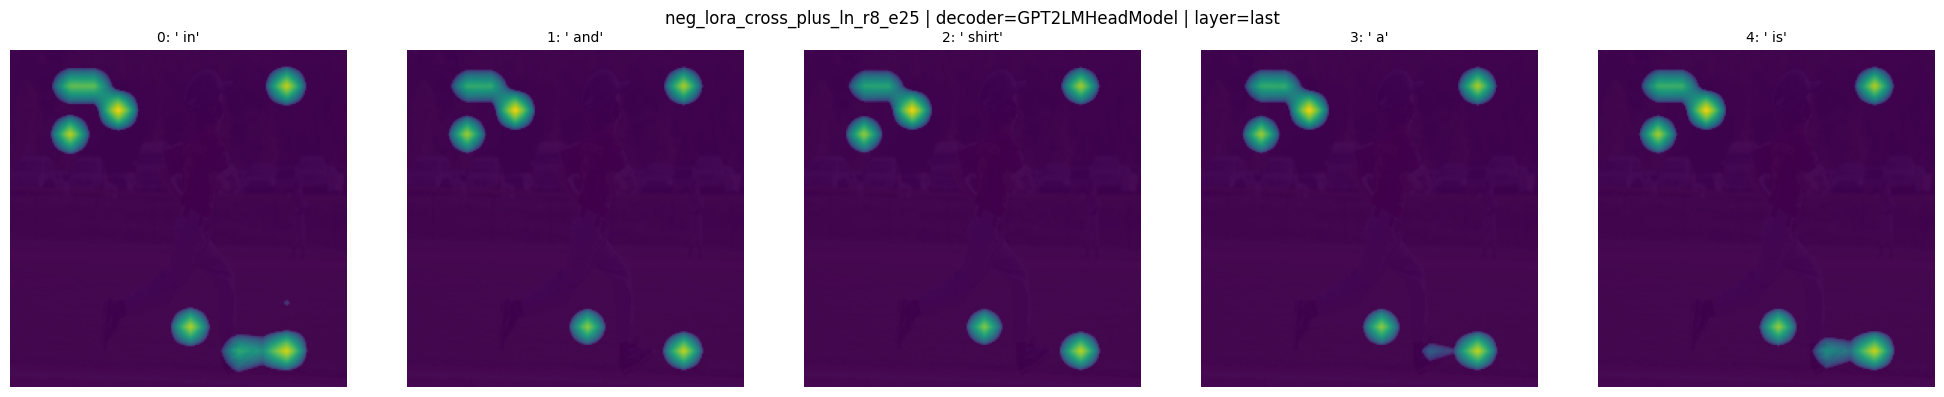

Generated tokens:
 in  ,  ,  ,  ,


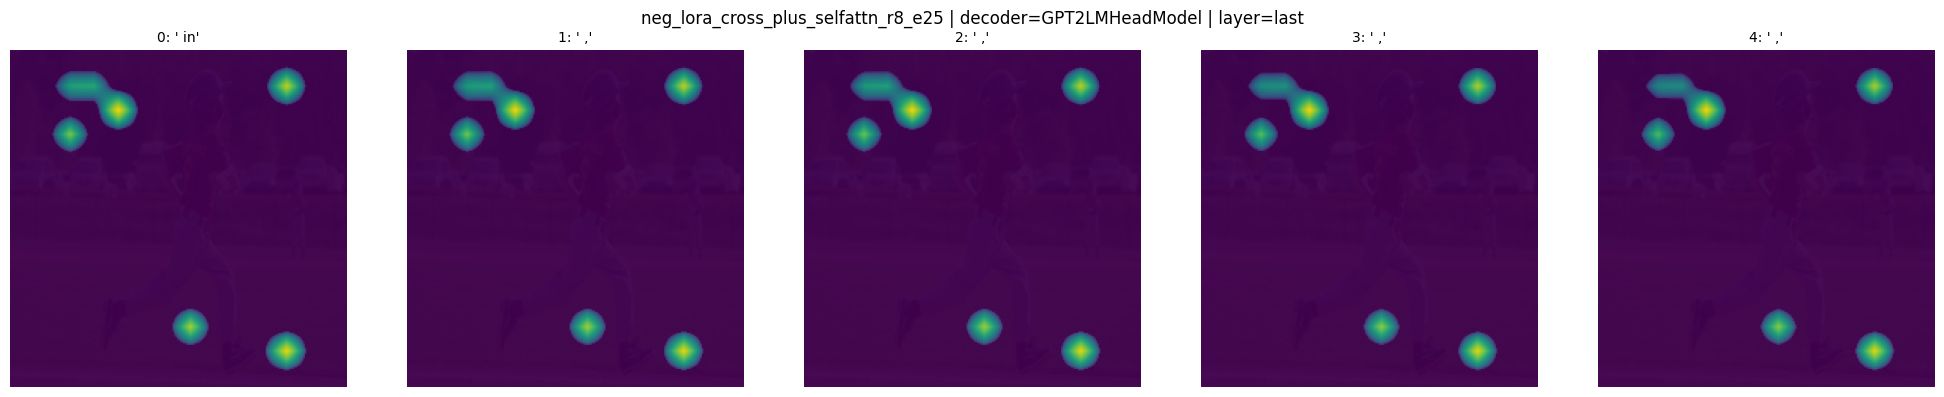

Generated tokens:
 boy  a  baseball  a  a


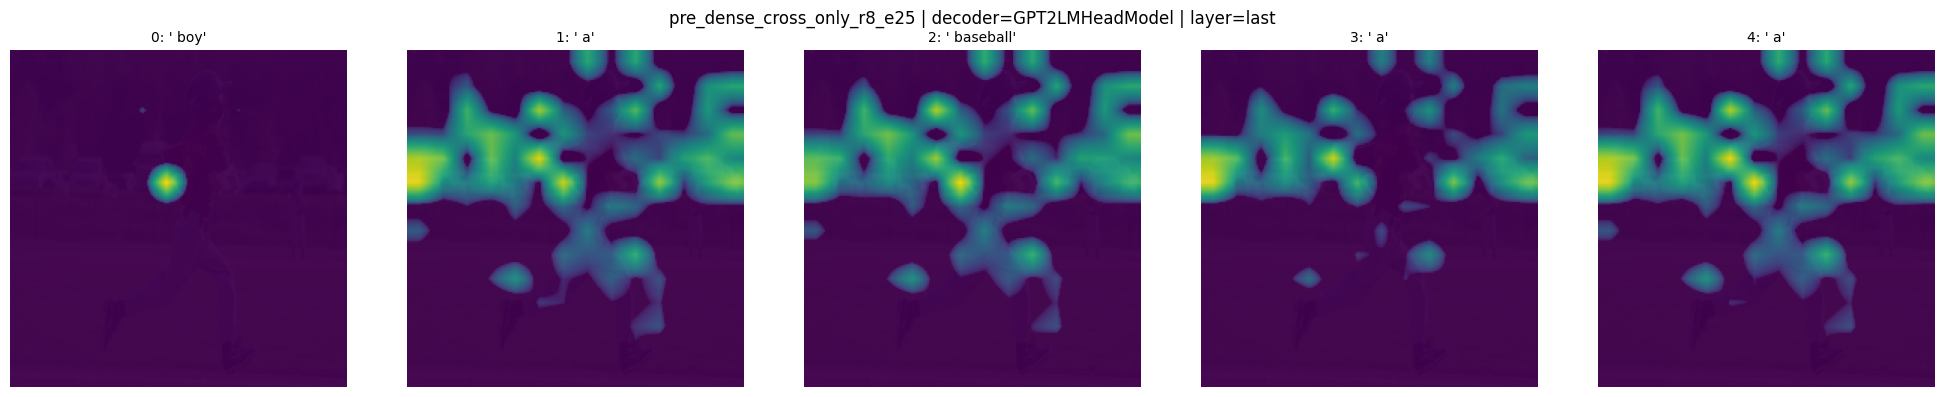

Generated tokens:
 in  uniform  a  baseball  a


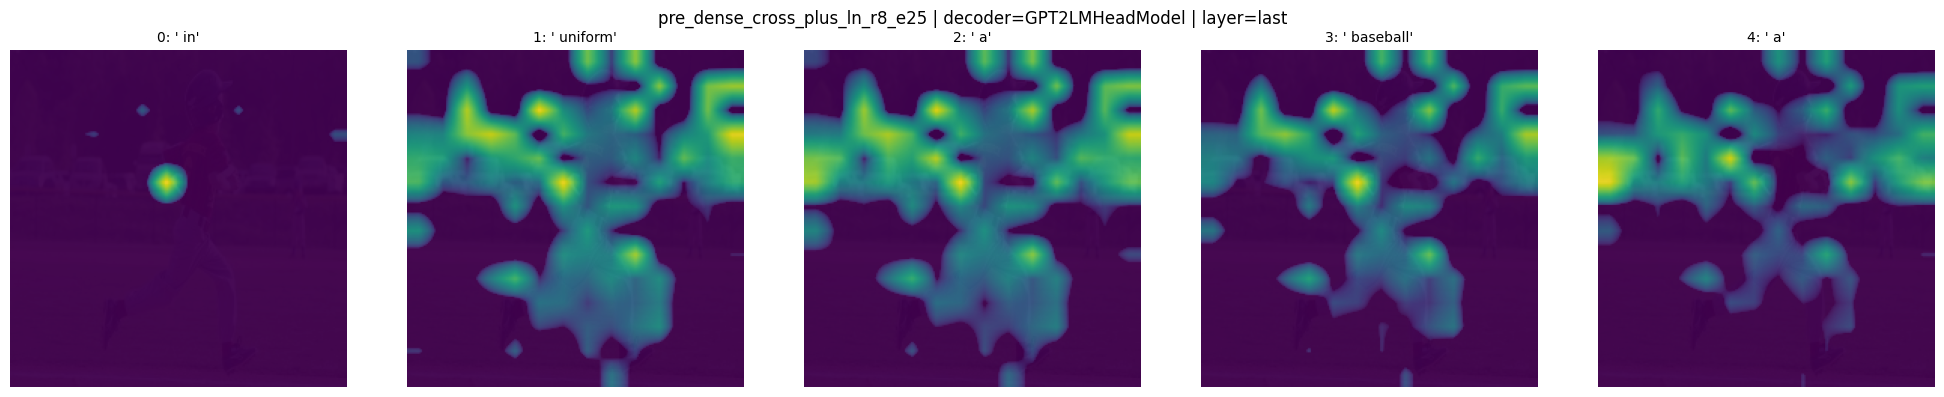

Generated tokens:
 player  a  baseball  a  a


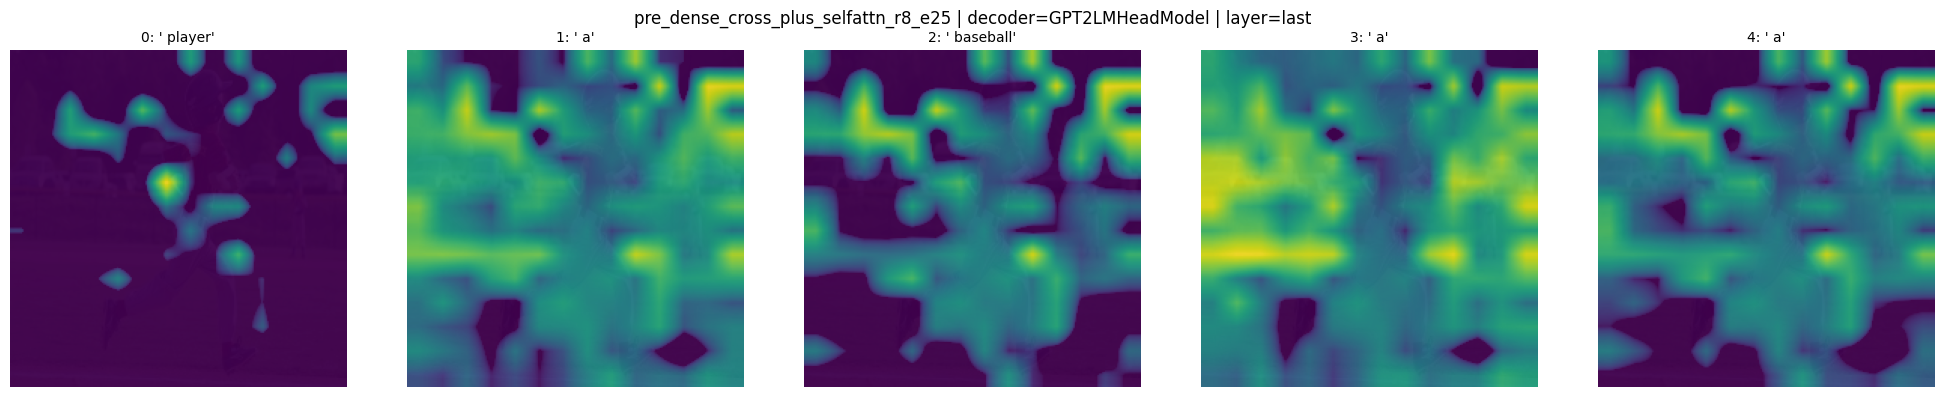

Generated tokens:
 in  uniform  a  player  a


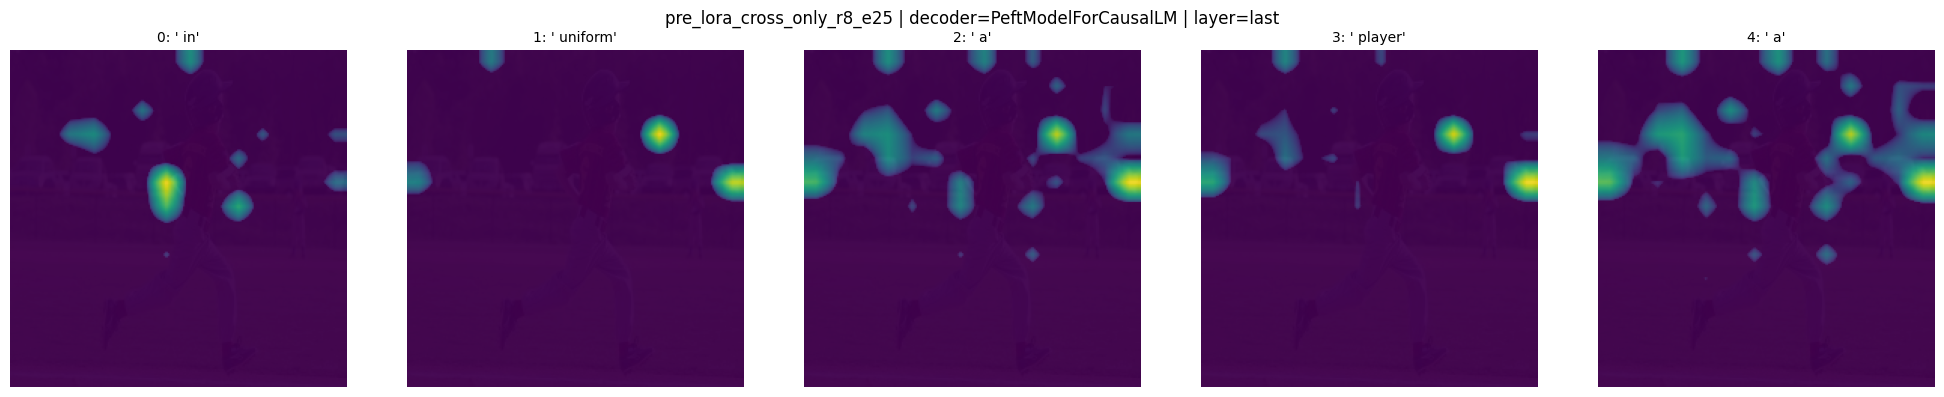

Generated tokens:
board er  in  red  and


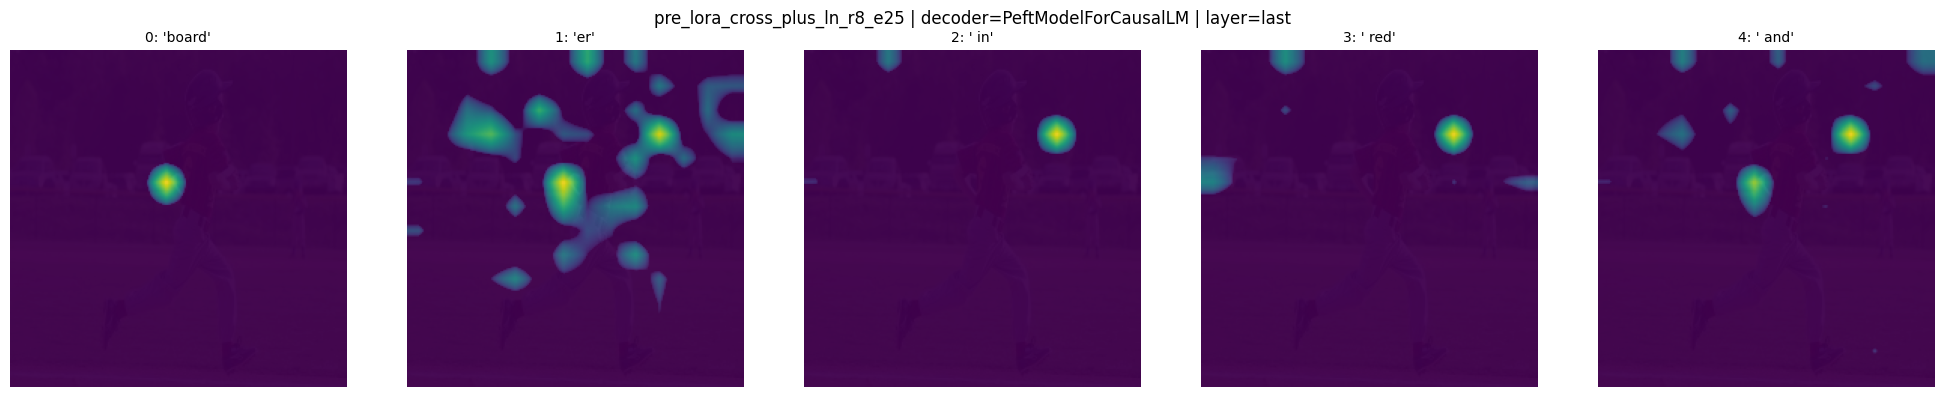

Generated tokens:
 player  a  is  a  in


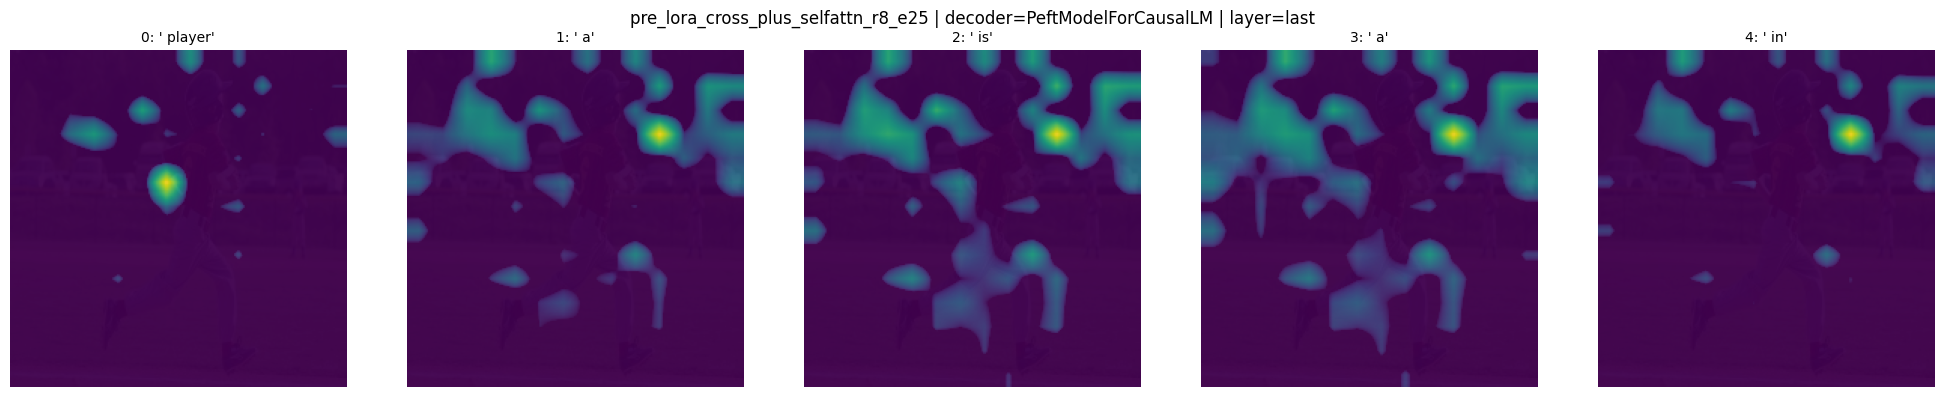

In [ ]:
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def _infer_patch_grid(model, processor=None):
    enc = model.encoder
    patch = getattr(enc.config, "patch_size", 16)
    img_size = getattr(enc.config, "image_size", None)

    if img_size is None and processor is not None and hasattr(processor, "size"):
        if isinstance(processor.size, dict):
            img_size = processor.size.get("height", 224)
        else:
            img_size = int(processor.size)

    img_size = img_size or 224
    g = img_size // patch
    return g, g

@torch.no_grad()
def _preprocess(processor, img_path):
    img = Image.open(img_path).convert("RGB")
    pv = processor(img, return_tensors="pt").pixel_values
    return img, pv

def _upsample_patchmap_to_image(patch_map_hw, img: Image.Image):
    heat = torch.tensor(patch_map_hw, dtype=torch.float32)[None, None, ...]
    heat = F.interpolate(heat, size=img.size[::-1], mode="bilinear", align_corners=False)[0, 0].cpu().numpy()
    heat = heat / (heat.max() + 1e-8)
    return heat

def _get_cross_attn_tensor(cross_attentions, mode="last"):
    if cross_attentions is None:
        return None
    valid = [x for x in cross_attentions if x is not None]
    if len(valid) == 0:
        return None
    if mode == "last":
        return valid[-1]
    elif mode == "avg":
        return torch.stack(valid, dim=0).mean(dim=0)
    else:
        raise ValueError("mode must be 'last' or 'avg'")

def _enhance_heat(heat01, *, thresh=0.2, gamma=0.6):
    """
    heat01: numpy array in [0,1]
    - thresh: pushes low values toward 0 (darker)
    - gamma < 1 boosts mid/high values
    """
    h = np.clip(heat01, 0.0, 1.0)
    h = (h - thresh) / (1.0 - thresh + 1e-8)   # shift/scale
    h = np.clip(h, 0.0, 1.0)
    h = np.power(h, gamma)                     # contrast
    return h

def _darken_image(img: Image.Image, strength=0.5):
    """
    strength in [0..1]; higher = darker. Returns float RGB in [0..1].
    """
    arr = np.asarray(img).astype(np.float32) / 255.0
    return np.clip(arr * (1.0 - strength), 0.0, 1.0)

def cross_attention_token_heatmaps(
    model,
    tokenizer,
    processor,
    img_path: str,
    prompt: str = "",
    max_new_tokens: int = 20,
    *,
    layer: str = "last",        # "last" or "avg"
    show_first_k: int = 12,
    figsize_per_token=(4, 4),   # size of each subplot
    heat_alpha=0.9,

    # --- enhancement knobs ---
    thresh: float = 0.2,
    gamma: float = 0.6,
    darken_strength: float = 0.55,

    # --- layout ---
    side_by_side: bool = True,
    suptitle: str | None = None,
):
    model.eval().to(DEVICE)

    # 1) Encode image once
    img, pv = _preprocess(processor, img_path)
    pv = pv.to(DEVICE)
    with torch.no_grad():
        enc_hid = model.encoder(pixel_values=pv, return_dict=True).last_hidden_state  # [1,1+N,D]

    # 2) Initial decoder input
    start_id = model.config.decoder_start_token_id or tokenizer.eos_token_id
    if start_id is None:
        raise RuntimeError("No decoder_start_token_id and tokenizer has no eos_token_id.")
    dec_ids = torch.tensor([[start_id]], device=DEVICE, dtype=torch.long)

    if prompt:
        prefix = tokenizer(prompt, add_special_tokens=False, return_tensors="pt").input_ids.to(DEVICE)
        dec_ids = torch.cat([dec_ids, prefix], dim=1)

    generated_ids, attn_vectors = [], []

    # 3) Greedy decode
    for _ in range(max_new_tokens):
        out = model.decoder(
            input_ids=dec_ids,
            encoder_hidden_states=enc_hid,
            encoder_attention_mask=None,
            use_cache=False,
            output_attentions=True,
            return_dict=True,
        )

        logits = out.logits[:, -1, :]
        next_id = torch.argmax(logits, dim=-1)  # [1]

        ca = _get_cross_attn_tensor(out.cross_attentions, mode=layer)
        if ca is None:
            has_ca_modules = any("crossattention" in n.lower() for n, _ in model.decoder.named_parameters())
            raise RuntimeError(
                "cross_attentions are all None.\n"
                f"- decoder has crossattention modules? {has_ca_modules}\n"
                "If you're using SDPA/flash attention, switch to eager for viz."
            )

        ca_step = ca[0]                 # [H, T, S]
        vec = ca_step.mean(dim=0)[-1]   # [S]
        vec = vec[1:]                   # drop CLS -> [N]
        vec = (vec / (vec.max() + 1e-8)).detach().cpu()
        attn_vectors.append(vec)

        tid = int(next_id.item())
        generated_ids.append(tid)
        dec_ids = torch.cat([dec_ids, next_id[:, None]], dim=1)

        if tokenizer.eos_token_id is not None and tid == tokenizer.eos_token_id:
            break

    gh, gw = _infer_patch_grid(model, processor)
    toks = [tokenizer.decode([tid]) for tid in generated_ids]

    print("Generated tokens:")
    print(" ".join([t.replace("\n", "\\n") for t in toks]))

    base_img = _darken_image(img, strength=darken_strength)

    k = min(len(generated_ids), show_first_k)
    if k == 0:
        print("No tokens generated to visualize.")
        return {"token_ids": generated_ids, "tokens": toks, "attn_vectors": attn_vectors}

    # ---- SIDE-BY-SIDE PLOTTING ----
    if side_by_side:
        fig_w = figsize_per_token[0] * k
        fig_h = figsize_per_token[1]
        fig, axes = plt.subplots(1, k, figsize=(fig_w, fig_h))
        if k == 1:
            axes = [axes]

        for i in range(k):
            vec = attn_vectors[i]
            if vec.numel() != gh * gw:
                n = int(np.sqrt(vec.numel()))
                gh, gw = n, n

            patch_map = vec.numpy().reshape(gh, gw)
            heat = _upsample_patchmap_to_image(patch_map, img)
            heat = _enhance_heat(heat, thresh=thresh, gamma=gamma)

            ax = axes[i]
            ax.imshow(base_img)
            ax.imshow(heat, alpha=heat_alpha)
            ax.axis("off")
            ax.set_title(f"{i}: {toks[i]!r}", fontsize=10)

        if suptitle is not None:
            fig.suptitle(suptitle, fontsize=12)
        plt.tight_layout()
        plt.show()

    else:
        # old behavior: one per line
        for i in range(k):
            vec = attn_vectors[i]
            if vec.numel() != gh * gw:
                n = int(np.sqrt(vec.numel()))
                gh, gw = n, n

            patch_map = vec.numpy().reshape(gh, gw)
            heat = _upsample_patchmap_to_image(patch_map, img)
            heat = _enhance_heat(heat, thresh=thresh, gamma=gamma)

            plt.figure(figsize=(5, 5))
            plt.imshow(base_img)
            plt.imshow(heat, alpha=heat_alpha)
            plt.axis("off")
            plt.title(f"step {i} token={toks[i]!r} (layer={layer})")
            plt.show()

    return {"token_ids": generated_ids, "tokens": toks, "attn_vectors": attn_vectors}

print("Image:", fn)
print("Caption:", caption_text)
# token_attribution_heatmap_first_k(model, tokenizer, processor, img_path, caption_text, 5)

img0 = Image.open(img_path).convert("RGB")
plt.figure(figsize=(5,5))
plt.imshow(img0)
plt.axis("off")
plt.title("Original")
plt.show()


for i, (run_name, model, tokenizer, processor) in enumerate(models):
    title = f"{run_name} | decoder={type(model.decoder).__name__} | layer=last"
    _ = cross_attention_token_heatmaps(
        model, tokenizer, processor, img_path,
        max_new_tokens=5,
        show_first_k=5,
        thresh=0.2, gamma=0.5,
        darken_strength=0.6,
        heat_alpha=0.9,
        side_by_side=True,
        suptitle=title,
    )

